# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: 3

Group Members: Julia Zhu, Devon Sandel, Taesoo Song, Tyrone Sgambati
 


## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [ ]:
# Load nhanes data
#nhanes = pd.read_csv('nhanes.csv')
nhanes = pd.read_csv('https://raw.githubusercontent.com/dlab-berkeley/Computational-Social-Science-Training-Program/main/Projects/Project%204/nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head(5)

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

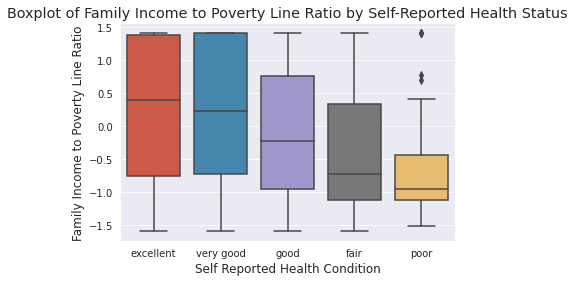

In [ ]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

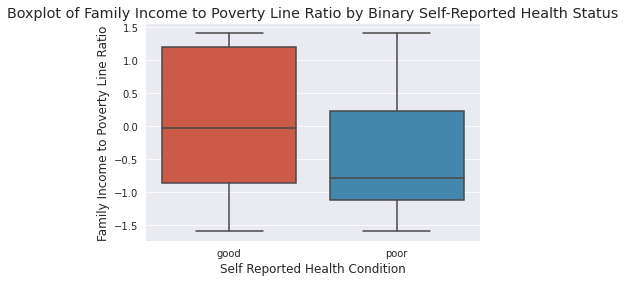

In [ ]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

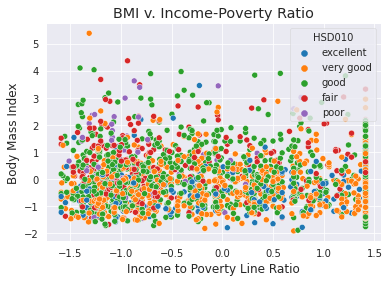

In [ ]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [ ]:
# Assign hsd010_binary separately
hsd010_binary = nhanes_scaled['HSD010_binary']

In [ ]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [ ]:
# Check the number of features
len(nhanes_scaled) # 2064 features

2064

The number of features we want to reduce from is 2064, which is a big size. Instead of first setting an exact number of how many components to produce, we first set an objective: we want to explain 70% of the variance in the original data. We then check how many number of components were produced and examine the scree and also the variance explained by the individual components to see if there is any cutoff point.

In [ ]:
# Conduct PCA
pca = PCA(n_components=0.70)
principalComponents_health = pca.fit_transform(nhanes_scaled)

In [ ]:
# Name the columns of the pca dataframe
pca_df = pd.DataFrame(data = principalComponents_health)
pca_df = pca_df.add_prefix('principal component ')
pca_df

,principal component 0,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,...,principal component 51,principal component 52,principal component 53,principal component 54,principal component 55,principal component 56,principal component 57,principal component 58,principal component 59,principal component 60
0,9.527811,-0.816224,-1.867091,-2.109908,-3.929375,-0.185332,-3.845128,-2.934825,1.514138,0.682613,...,-0.875938,-0.736273,-0.304707,0.398774,0.227135,0.496242,-0.848105,1.022960,-0.320904,0.367153
1,-5.838339,-3.692573,3.805749,-1.029680,0.394578,1.593149,2.711101,-0.740594,0.384751,-2.406291,...,0.965434,1.567285,-2.728604,-1.247977,2.964072,-0.420644,-1.532538,0.396490,-3.493647,-0.612452
2,-0.719454,-2.573200,0.907904,-4.755854,-1.798847,0.863651,-1.024494,0.633063,0.542111,0.449352,...,-1.175747,-1.150908,1.041487,-0.770396,-0.673977,-1.087375,-0.316598,0.574932,-0.455722,0.130889
3,3.533627,-2.576982,-3.249124,-0.405426,3.999037,1.444511,-1.182086,0.326650,-4.151250,-1.245445,...,-0.376540,0.188075,0.968460,-1.054774,-1.734217,0.583690,0.655421,-0.081852,-0.301204,0.413456
4,-6.872094,-4.194241,0.886831,-0.848954,-0.524848,0.073034,0.843855,0.987843,0.556969,-0.045043,...,-0.800867,-0.152474,0.511647,-0.692591,-1.207002,-0.279466,0.528789,0.647430,0.553934,-1.171154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,2.643319,-1.689356,-0.702592,-0.538271,-1.021631,-0.677038,0.473200,-0.289046,0.958981,-1.238172,...,0.519318,0.545385,-0.310751,0.905775,-0.103812,0.229087,-0.634472,-0.055687,0.685134,0.001407
2060,1.037906,-0.118065,5.556454,1.630069,0.967776,1.146811,1.949434,0.929057,-1.286747,-2.011509,...,0.801897,-0.451178,-0.628533,0.492959,-1.617688,1.516501,-0.250441,-0.371675,-0.383842,-0.122313
2061,1.130253,-0.970432,3.415389,1.206787,-3.631819,1.118396,1.361640,1.827686,-2.339055,0.232205,...,-0.201970,1.131327,2.007375,0.535570,1.197020,-0.744448,1.525740,1.004516,-0.027806,0.462720
2062,7.145093,-0.376752,1.753506,-0.939028,-4.665513,3.844304,-1.355161,2.587567,-0.289915,0.612763,...,-1.155695,-1.367484,-0.165320,-0.657431,-0.737803,0.155531,-0.008829,0.845579,-0.144534,0.923776


### Barplot of Components

In [ ]:
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)
len(exp_var) # Check how many components were produced

61

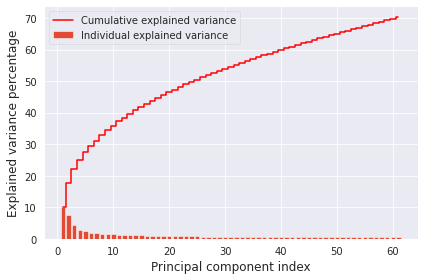

In [ ]:
# Plot a bar graph explaining individual and cumulative explained variance
plt.bar(range(1, 62), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 62), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
# plt.xticks(ticks=[1, 2, 3, 4])
plt.legend(loc='best')
plt.tight_layout()

Text(0.5, 1.0, 'Scree Plot')

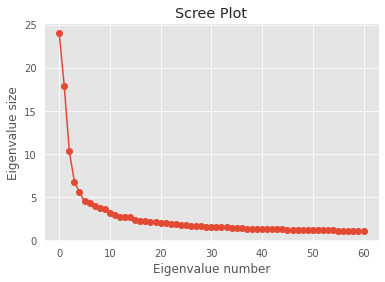

In [ ]:
# Draw a scree plot
plt.style.use("ggplot")
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

### How many components will you use to fit a supervised learning model?

From the graphs plotted above, we can observe that the first component only explains 10% of the original data variance; The eigenvalue significantly drops after the 4-5th component but choosing these number of components would retain only about 30% of the original data variance. Hence, we choose to retrain the same model with 61 components.

### 2D Scatterplot of the first two components

In [ ]:
# Append the hsd010_binary feature to the PCA results dataframe
pca_df['hsd010_binary'] = hsd010_binary.tolist()

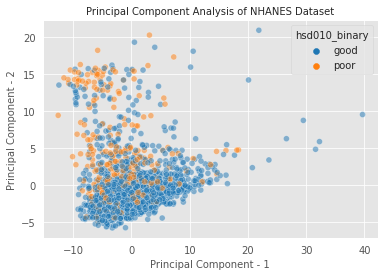

In [ ]:
# Draw a scatterplot
plt.figure()
pca_plot = sns.scatterplot(x = "principal component 0", y = "principal component 1", hue = "hsd010_binary",
                           palette="tab10",
                           data = pca_df, alpha=0.5)
plt.xlabel('Principal Component - 1',fontsize=10)
plt.ylabel('Principal Component - 2',fontsize=10)
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=10)
plt.show()

The first two principal components do not seem to have any obvious linear relationship with each other. This is probably because PCA is a method for "condensing" information in the dataset by reducing the number of features; it would not make sense for the two components were closely linearly related to each other.

In [ ]:
# Drop the hsd010_binary feature
pca_df2 = pca_df.drop(['hsd010_binary'], axis=1)

## K-Means (Julia Zhu)

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

We choose K-means clustering, one of the simplest and popular unsupervised machine learning algorithms. Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes.

### Cluster nhanes

In [ ]:
X = nhanes_scaled
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)

KMeans(random_state=42)

### choosing the best value for K

We used silhouette_score to select the best value for k in clustering. Silhouette score is used to evaluate the quality of clusters created using clustering algorithms such as K-Means in terms of how well samples are clustered with other samples that are similar to each other. The Silhouette score is calculated for each sample of different clusters. The larger silhouette_score is, the better the clustering is.

As shown below, we compared the silhouette_score values for different option for k (from 2 to 8), and the results show that the silhouette_score is the largest when k is 2. 

In [ ]:
## Your Answer Here

# using s-score to choose the best K
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
result = {}
for k in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator seed of 42 for reproducibility.
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    # Compute the corresponding s-score
    labels = kmeans.labels_ #Check the labels if you change the n_clusters to 3
    score = silhouette_score(X, kmeans.labels_)
    result[k] = score 
    print("For n_clusters =", k, "The average silhouette_score is :",score) 

  #get the best s-score and the best K
best_score = max(result.values())
best_k = max(result, key = result.get)
print("The max silhouette_score is:", best_score, "when k is:", best_k) 

For n_clusters = 2 The average silhouette_score is : 0.23039328085803387
For n_clusters = 3 The average silhouette_score is : 0.08455413891673565
For n_clusters = 4 The average silhouette_score is : 0.03842812266018131
For n_clusters = 5 The average silhouette_score is : 0.0341477026698987
For n_clusters = 6 The average silhouette_score is : 0.025048829084662518
For n_clusters = 7 The average silhouette_score is : 0.01914789954794879
For n_clusters = 8 The average silhouette_score is : 0.01477334134416473
The max silhouette_score is: 0.23039328085803387 when k is: 2


In [ ]:
# use k=2 to do clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_ 
clusters = kmeans.cluster_centers_

In [ ]:
nhanes_scaled['labels']= labels

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

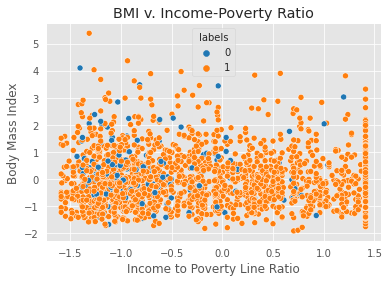

In [ ]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "labels", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

### We plotted the two clusters on top of BMI vs. Income Poverty Ratio plot as above. 

As shown by the plot, majority of the points belong to cluster 1 (colored in orange) and a small portition belongs to cluster 0 (colored in blue). The points belonging to cluster 1 are distributed relatively evenly across different levels of income to poverty line ratio, while those belonging to cluster 0 are distributed densely among the population whose income to poverty ratio is below 0. And the points of either clustering 1 or 0 distribute relatively evenly across different BMI levels. 


### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [ ]:
## Your Answer Here
X = pca_df2

# using s-score to choose the best K
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
result = {}
for k in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator seed of 42 for reproducibility.
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    # Compute the corresponding s-score
    score = silhouette_score(X, kmeans.labels_)
    result[k] = score 
    print("For n_clusters =", k, "The average silhouette_score is :",score) 

  #get the best s-score and the best K
best_score = max(result.values())
best_k = max(result, key = result.get)
print("The max silhouette_score is:", best_score, "when k is:", best_k) 

For n_clusters = 2 The average silhouette_score is : 0.2727747861425518
For n_clusters = 3 The average silhouette_score is : 0.11924633557580228
For n_clusters = 4 The average silhouette_score is : 0.06523846632790366
For n_clusters = 5 The average silhouette_score is : 0.05124841548151883
For n_clusters = 6 The average silhouette_score is : 0.04870979928793244
For n_clusters = 7 The average silhouette_score is : 0.046315070760491274
For n_clusters = 8 The average silhouette_score is : 0.04633970840858582
The max silhouette_score is: 0.2727747861425518 when k is: 2


In [ ]:
pca_df['principal component 0'].dtype

dtype('float64')

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_ 
clusters = kmeans.cluster_centers_
pca_df2['labels2']= labels

Text(0.5, 1.0, 'clustering result based on PCA')

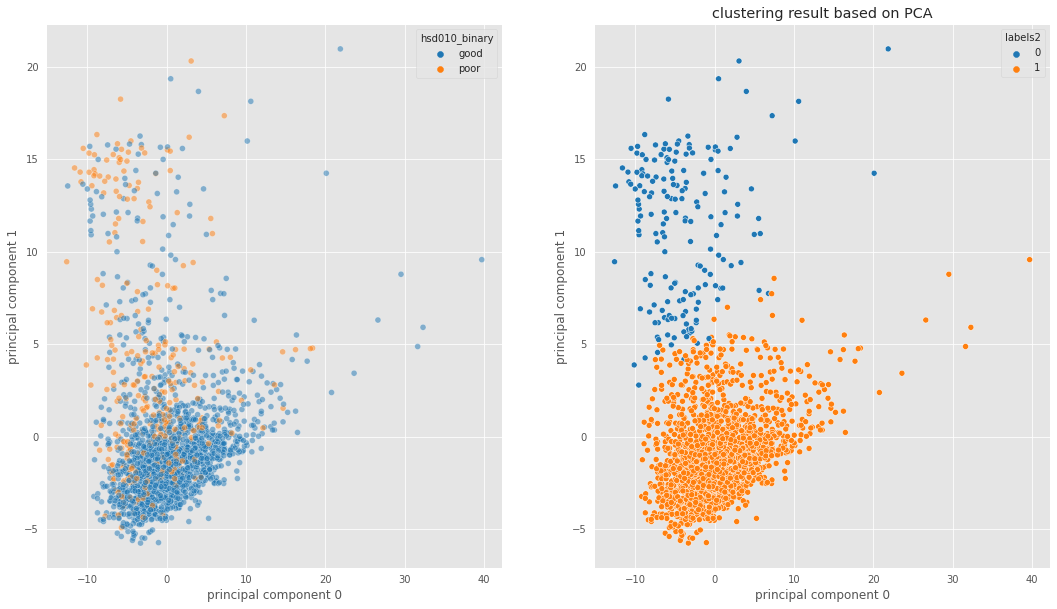

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

#previous plot from PCA
pca_plot = sns.scatterplot(ax=axes[0],x = "principal component 0", y = "principal component 1", hue = "hsd010_binary",
                           palette="tab10",
                           data = pca_df, alpha=0.5)
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=10)

#plot for clustering based on PCA result
ax = sns.scatterplot(ax=axes[1],x = "principal component 0", y = "principal component 1", hue = "labels2", palette = "tab10", data = pca_df2)
ax.set(xlabel = "principal component 0",
      ylabel = "principal component 1")
ax.set_title("clustering result based on PCA")


#### Comapring PCA graph and clustering result 

As seen from the two graphs above, the clustering based on PCA result performs well at separating those in good condition and poor condition. Cluster 1 overlaps greatly with those with good conditions, while cluster 2 overlaps a lot with those with poor conditions. The boundaries between two clusters are much clearer than simply using income and BMI as two predicting factors, and this indicates that primary principle components have much greater predictability power than two randomly selected features. That said, clustering result based on only two principle components cannot perfectly separate those in good and poor conditions apart. As shown by the two graphs, a noticable portion of points still get miscategorized.  

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
y = np.array(hsd010.astype('int')) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
import sklearn.preprocessing as pp

lb = pp.LabelBinarizer()

y_train = lb.fit_transform(y_train)

y_test = lb.fit_transform(y_test)

#Was having big issues with keras' to_categorical so switched to LabelBinarizer()


In [ ]:
model = Sequential()

model.add(
    Dense(5000, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')
)

model.add(
    Dense(X_train.shape[1], kernel_initializer='normal', activation='relu')
)

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax')
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 1.9986 - accuracy: 0.3443 - val_loss: 1.4148 - val_accuracy: 0.4419 - 1s/epoch - 134ms/step
Epoch 2/10
8/8 - 0s - loss: 1.0496 - accuracy: 0.5814 - val_loss: 1.2600 - val_accuracy: 0.4457 - 495ms/epoch - 62ms/step
Epoch 3/10
8/8 - 1s - loss: 0.7823 - accuracy: 0.7248 - val_loss: 1.3084 - val_accuracy: 0.4612 - 509ms/epoch - 64ms/step
Epoch 4/10
8/8 - 0s - loss: 0.5706 - accuracy: 0.8172 - val_loss: 1.3003 - val_accuracy: 0.4787 - 489ms/epoch - 61ms/step
Epoch 5/10
8/8 - 0s - loss: 0.4053 - accuracy: 0.8928 - val_loss: 1.3339 - val_accuracy: 0.4593 - 498ms/epoch - 62ms/step
Epoch 6/10
8/8 - 0s - loss: 0.2848 - accuracy: 0.9470 - val_loss: 1.3933 - val_accuracy: 0.4806 - 482ms/epoch - 60ms/step
Epoch 7/10
8/8 - 0s - loss: 0.1907 - accuracy: 0.9864 - val_loss: 1.4607 - val_accuracy: 0.4748 - 499ms/epoch - 62ms/step
Epoch 8/10
8/8 - 1s - loss: 0.1297 - accuracy: 0.9987 - val_loss: 1.5349 - val_accuracy: 0.4845 - 514ms/epoch - 64ms/step
Epoch 9/10
8/8 - 1s - loss

### Neural Network on Principal Components

In [ ]:
y = np.array(hsd010.astype('int')) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = pca_df.drop(["hsd010_binary"], axis = 1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
y_train = lb.fit_transform(y_train)

y_test = lb.fit_transform(y_test)

In [ ]:
model = Sequential()

model.add(
    Dense(5000, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')
)

model.add(
    Dense(X_train.shape[1], kernel_initializer='normal', activation='relu')
)

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax')
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 1.4049 - accuracy: 0.3811 - val_loss: 1.2518 - val_accuracy: 0.4438 - 994ms/epoch - 124ms/step
Epoch 2/10
8/8 - 0s - loss: 1.1064 - accuracy: 0.5239 - val_loss: 1.2430 - val_accuracy: 0.4593 - 199ms/epoch - 25ms/step
Epoch 3/10
8/8 - 0s - loss: 0.9879 - accuracy: 0.5975 - val_loss: 1.2318 - val_accuracy: 0.4632 - 189ms/epoch - 24ms/step
Epoch 4/10
8/8 - 0s - loss: 0.8786 - accuracy: 0.6583 - val_loss: 1.2392 - val_accuracy: 0.4845 - 192ms/epoch - 24ms/step
Epoch 5/10
8/8 - 0s - loss: 0.7848 - accuracy: 0.7080 - val_loss: 1.2499 - val_accuracy: 0.4593 - 183ms/epoch - 23ms/step
Epoch 6/10
8/8 - 0s - loss: 0.7022 - accuracy: 0.7552 - val_loss: 1.2833 - val_accuracy: 0.4632 - 193ms/epoch - 24ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6109 - accuracy: 0.8062 - val_loss: 1.3244 - val_accuracy: 0.4535 - 183ms/epoch - 23ms/step
Epoch 8/10
8/8 - 0s - loss: 0.5336 - accuracy: 0.8417 - val_loss: 1.3789 - val_accuracy: 0.4399 - 182ms/epoch - 23ms/step
Epoch 9/10
8/8 - 0s - l

### Neural Network on Principal Components + Cluster Membership

In [ ]:
cluster_labels_df = lb.fit_transform(labels)
cluster_labels_df = pd.DataFrame(cluster_labels_df,columns = ['Cluster 1v2'])

features = pd.concat([pca_df, cluster_labels_df], axis=1)

y = np.array(hsd010.astype('int')) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = features.drop(["hsd010_binary"], axis = 1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
y_train = lb.fit_transform(y_train)

y_test = lb.fit_transform(y_test)

In [ ]:
model = Sequential()

model.add(
    Dense(5000, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')
)

model.add(
    Dense(X_train.shape[1], kernel_initializer='normal', activation='relu')
)

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax')
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

Epoch 1/10
8/8 - 1s - loss: 1.4179 - accuracy: 0.4141 - val_loss: 1.2743 - val_accuracy: 0.4535 - 775ms/epoch - 97ms/step
Epoch 2/10
8/8 - 0s - loss: 1.1173 - accuracy: 0.5323 - val_loss: 1.2415 - val_accuracy: 0.4419 - 175ms/epoch - 22ms/step
Epoch 3/10
8/8 - 0s - loss: 0.9864 - accuracy: 0.5930 - val_loss: 1.2578 - val_accuracy: 0.4438 - 188ms/epoch - 24ms/step
Epoch 4/10
8/8 - 0s - loss: 0.8822 - accuracy: 0.6421 - val_loss: 1.2701 - val_accuracy: 0.4574 - 183ms/epoch - 23ms/step
Epoch 5/10
8/8 - 0s - loss: 0.7884 - accuracy: 0.7003 - val_loss: 1.2855 - val_accuracy: 0.4535 - 186ms/epoch - 23ms/step
Epoch 6/10
8/8 - 0s - loss: 0.7067 - accuracy: 0.7442 - val_loss: 1.2827 - val_accuracy: 0.4516 - 205ms/epoch - 26ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6142 - accuracy: 0.8017 - val_loss: 1.3307 - val_accuracy: 0.4612 - 184ms/epoch - 23ms/step
Epoch 8/10
8/8 - 0s - loss: 0.5353 - accuracy: 0.8391 - val_loss: 1.3722 - val_accuracy: 0.4496 - 183ms/epoch - 23ms/step
Epoch 9/10
8/8 - 0s - lo

**Compare and contrast how well each algorithm did. Which featurization
technique would you pick and why?**

Frankly, these three feature-selection methods produced almost indistinguishable results. In terms of accuracy, in the validation data the initial algorithm finished with the highest accuracy (0.457) followed by the PCA + clusters (0.453) and PCA-alone (0.447). These differences seem negligible. However, I did some reading that suggested it is advisable to stop the algorithm from iterating through more epochs once val_accuracy begins to decrease. If we were to have done this, PCA alone achieved the highest val accuracy (0.490), followed by PCA + clustering (0.486), and finally the full feature space (0.470). This maps more closely to my intuitions about the benefit of reducing prediction noise by performing dimensionality reduction. As I see it, PCA-alone captures the important predictive information from the data. 

One additional advantage to the PCA-alone approach is the quickest runtime. Because there are fewer features, training was less time-intensive. Adding clustering information didn't cause a noticeable increase in time, but training with the full feature space was significantly slower.


## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is used for dimension reduction (reducing the total number of variables of interest to fewer summarizing variables), whereas clustering is used to generate clusters of variables based on the dataset which may represent "types" within the data.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

There was a small increase in accuracy by combining PCA and clustering, compared to PCA alone. One advantage of combining PCA and clustering is an overall greater reduction of dimensions of interest. In very large datasets, this further dimension reduction may be useful. The PCA step may also reduce noise in your data, so the clustering step would generate more distinct and interpretable clusters.


3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA and clustering can help downstream supervised learning by reducing the number of variables of importance. This is an automated way of simplifying huge datasets for more parsimonious models. Unsupervised techniques preceding supervised techniques can also provide useful info to return to once the supervised step is done. For example, an algorithm which predicts which Netflix show someone will watch given certain variables is useful, but the team designing new shows may also be interested in what characteristics make up these clusters of people, and how many fall in each cluster.